# LM-FBS with a Bespoke Function
This notebook couples the 2DOF systems together with a bespoke LM-FBS  python function to show how the method can be used with relatively little code. As a reminder, a graphic of the FBS coupling is shown below, where system A is on the left, system B is on the right, and the coupled system is in the center. 

![Two_DOF_System](./Images/TwoMassSystem.svg)

## Importing and Defining the Fundamental Functions for the Example
This section imports the necessary packages and defines a function for the FBS coupling that uses the LM-FBS method.

In [1]:
import numpy as np
import sdynpy as sdpy
import matplotlib.pyplot as plt

### Bespoke LM-FBS Function
This function implements the LM-FBS method, using the following equation:

$$
\begin{bmatrix}H^{ab}\end{bmatrix}=\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}-\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}\begin{bmatrix}B_{ref}\end{bmatrix}^T\begin{pmatrix}\begin{bmatrix}B_{res}\end{bmatrix}\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}\begin{bmatrix}B_{ref}\end{bmatrix}^T\end{pmatrix}^+\begin{bmatrix}B_{res}\end{bmatrix}\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}
$$

```{note}
The coupling is performed in four lines of code, demonstrating the computational simplicity of the LM-FBS method. 
```

In [2]:
def fbs_coupling(block_diagonal_frf, b_res, b_ref, remove_extra_dof=False):
    """
    Performs frequency based substructuring with the Lagrange multiplier method.

    Parameters
    ----------
    block_diagonal_frf: ndarray
        The FRFs to be coupled, in block diagonal format. Should be organized 
        such that [frequency, responses, references]
    b_res: ndarray
        The signed boolean constraint matrix for the response degrees of freedom.
        Should be organized [number of constraints, number of responses].
    b_ref: ndarray
        The signed boolean constraint matrix for the reference degrees of freedom.
        Should be organized [number of constraints, number of references]. 
    remove_extra_dof : bool
        Whether the duplicated coupling DOF should be eliminated from the coupled
        FRF matrix. The default is False, meaning that the duplicated DOF is not
        removed. 

    Returns
    -------
    coupled_frf: ndarray
        The coupled FRFs, organized [frequency, responses, references].

    Notes
    -----
    The duplicated DOFs are deleted from the FRF matrix, based on where the B
    matrices are negative. 
    """
    kernel = np.linalg.pinv(b_res[np.newaxis, ...]@block_diagonal_frf@b_ref.T[np.newaxis, ...])
    coupled_frf = block_diagonal_frf - (block_diagonal_frf@b_ref.T[np.newaxis, ...]@kernel
                                          @b_res[np.newaxis, ...]@block_diagonal_frf)
    if remove_extra_dof:
        coupled_frf = np.delete(coupled_frf, np.where(b_res==-1)[1], axis=1)
        coupled_frf = np.delete(coupled_frf, np.where(b_ref==-1)[1], axis=2)
    return coupled_frf

## Importing the FRFs
This section imports the FRFs (as SDynPy `TransferFunctionArrays`) from the 2DOF example systems. These FRFs will be called `system_a_frfs`, `system_b_frfs`, and `coupled_system_frfs` based on the system that they are representative of. 

In [3]:
system_a_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_a_frfs.npz')
system_b_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_b_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_system_frfs.npz')

### Organization of the FRF Matrices
It is critical that we know the organization of the source FRFs to accurately apply manual FBS. As such, the response and reference DOF organization for the system A and system B FRFs will be shown here. 

#### System A FRF Organization

In [4]:
print("The response DOF organization for the system A FRFs is:")
print(system_a_frfs.response_coordinate)

The response DOF organization for the system A FRFs is:
[['1X+' '1X+']
 ['2X+' '2X+']]


In [5]:
print("The reference DOF organization for the system A FRFs is:")
print(system_a_frfs.reference_coordinate)

The reference DOF organization for the system A FRFs is:
[['1X+' '2X+']
 ['1X+' '2X+']]


#### System A FRF Organization

In [6]:
print("The response DOF organization for the system B FRFs is:")
print(system_b_frfs.response_coordinate)

The response DOF organization for the system B FRFs is:
[['3X+' '3X+']
 ['4X+' '4X+']]


In [7]:
print("The reference DOF organization for the system B FRFs is:")
print(system_b_frfs.reference_coordinate)

The reference DOF organization for the system B FRFs is:
[['3X+' '4X+']
 ['3X+' '4X+']]


## Generating the Block Diagonal FRF Matrix
The block diagonal FRF matrix (named `block_diagonal_frf`) will be generated by creating an appropriately shaped array of zeros, then filling the correct locations with the system A and B FRFs. 

```{tip}
In most practical cases, it would be useful to reshape the `TransferFunctionArrays` for the different systems by indexing with `CoordinateArrays` to ensure that the FRFs are organized correctly for the coupling. This reshaping isn't used here because of prior knowledge of how the FRFs are organized.
```

In [8]:
block_diagonal_frf = np.zeros((601, 4, 4), dtype=complex)

block_diagonal_frf[:, :2, :2] = np.moveaxis(system_a_frfs.ordinate, -1, 0)
block_diagonal_frf[:, 2:, 2:] = np.moveaxis(system_b_frfs.ordinate, -1, 0)

## Generating the B Matrix
The B matrix for this example is shaped (1, 4) because there is a single coupling constraint and four response/reference DOFs in the block diagonal FRF matrix. We can figure out where to put the boolean values by looking at the concatenated DOFs from the system A and B `TransferFunctionArrays`, as shown below for the response and reference DOFs (referred to as coordinates in the SDynPy package). 

### Concatenated Response DOFs for the Block Diagonal FRFs

In [9]:
print(np.concatenate((system_a_frfs[:,0].response_coordinate, 
                      system_b_frfs[:,0].response_coordinate)))

['1X+' '2X+' '3X+' '4X+']


### Concatenated Reference DOFs for the Block Diagonal FRFs

In [10]:
print(np.concatenate((system_a_frfs[0,:].reference_coordinate, 
                      system_b_frfs[0,:].reference_coordinate)))

['1X+' '2X+' '3X+' '4X+']


### The B Matrix
It can be seen that the concatenated response and reference DOFs are the exact same, which means that the response and reference B matrices will be the same. The respective B matrices are labeled as `b_response` and `b_reference`. Note that the 1 and -1 could be flipped, if desired. 

```{note}
While it was simple to manually create the B matrices in this example, it would be much more difficult in cases with more response/reference DOFs and more coupling DOFs. Errors in generating the B matrices typically lead to significant errors in the resulting FRFs so practitioners need to take significant efforts that the B matrices are correct for each LM-FBS application.
```

In [11]:
b_response = b_reference = np.array([0, 1, -1, 0])[np.newaxis,...]

## Raw LM-FBS Coupling
Like the other FBS coupling examples, the raw FRF matrix from LM-FBS coupling has the same shape as the block diagonal FRF matrix with duplicate FRFs at the (response and reference) coupling DOFs. The equivalency of the duplicate FRFs is shown below with the `allclose` and graphical comparisons. 

In [12]:
fbs_coupled_frfs_all_dofs = fbs_coupling(block_diagonal_frf, b_response, 
                                         b_reference, remove_extra_dof=False)
print('The shape of the FBS coupled FRF matrix is: {:}'.format(fbs_coupled_frfs_all_dofs.shape))

The shape of the FBS coupled FRF matrix is: (601, 4, 4)


In [13]:
if np.allclose(fbs_coupled_frfs_all_dofs[:, 1, :], fbs_coupled_frfs_all_dofs[:, 2, :]):
    print('All the FRFs with response DOFs two and three are the same')

All the FRFs with response DOFs two and three are the same


In [14]:
if np.allclose(fbs_coupled_frfs_all_dofs[:, :, 1], fbs_coupled_frfs_all_dofs[:, :, 2]):
    print('All the FRFs with reference DOFs two and three are the same')

All the FRFs with reference DOFs two and three are the same


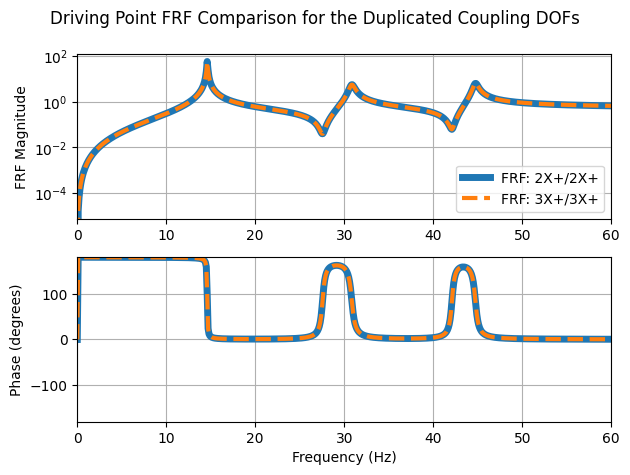

In [15]:
freq = system_a_frfs.ravel().abscissa[0]

fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_all_dofs[:, 1, 1]), label='FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_all_dofs[:, 2, 2]), label='FRF: 3X+/3X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(fbs_coupled_frfs_all_dofs[:, 1, 1])*180/np.pi, 
           linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_all_dofs[:, 2, 2])*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point FRF Comparison for the Duplicated Coupling DOFs')
fig.set_tight_layout(tight='tight')

## FBS Coupling and Removing the Duplicated DOF
This section redoes the FBS coupling and removes the duplicated coupling DOF by setting the `remove_extra_dof` kwarg in the supplied function to `True`. The function algorithmically removes the extra DOF with a simple logical check by the locations where b_response and b_reference is -1. With the duplicated DOF removed, a simple equivalency comparison shows that the truth FRFs from the coupled system and LM-FBS coupling are exactly the same. This similarity is also shown in a graphical comparison of the driving point FRFs. 

In [16]:
fbs_coupled_frfs_removed_dofs = fbs_coupling(block_diagonal_frf, b_response, 
                                             b_reference, remove_extra_dof=True)
truth_frf_ord = np.moveaxis(coupled_system_frfs.ordinate, -1, 0)

if np.allclose(fbs_coupled_frfs_removed_dofs, truth_frf_ord):
    print('The FRFs from the LM-FBS coupling are exactly the same as the FRFs from the truth system')

The FRFs from the LM-FBS coupling are exactly the same as the FRFs from the truth system


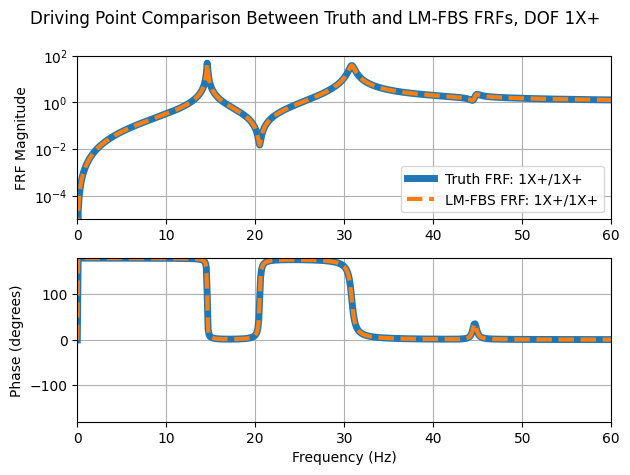

In [17]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(truth_frf_ord[:, 0, 0]), label='Truth FRF: 1X+/1X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[:, 0, 0]), label='LM-FBS FRF: 1X+/1X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(truth_frf_ord[:, 0, 0])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[:, 0, 0])*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and LM-FBS FRFs, DOF 1X+')
fig.set_tight_layout(tight='tight')

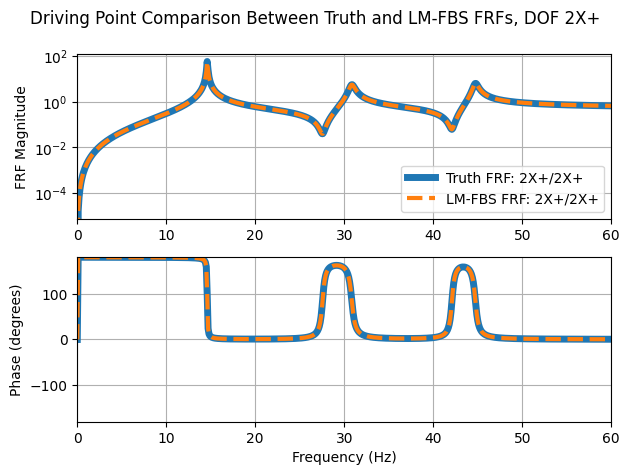

In [18]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(truth_frf_ord[:, 1, 1]), label='Truth FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[:, 1, 1]), label='LM-FBS FRF: 2X+/2X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(truth_frf_ord[:, 1, 1])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[:, 1, 1])*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and LM-FBS FRFs, DOF 2X+')
fig.set_tight_layout(tight='tight')

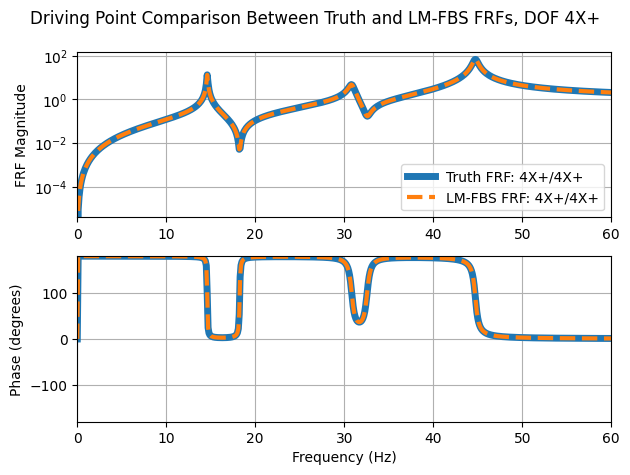

In [19]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(truth_frf_ord[:, 2, 2]), label='Truth FRF: 4X+/4X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[:, 2, 2]), label='LM-FBS FRF: 4X+/4X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(truth_frf_ord[:, 2, 2])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[:, 2, 2])*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and LM-FBS FRFs, DOF 4X+')
fig.set_tight_layout(tight='tight')

## Conclusions
This notebook has shown how the LM-FBS function dramatically simplifies the FBS process since a simple, compact, and universal function can be used to do the coupling. However, this method still has several pitfalls related to bookkeeping since the block diagonal FRFs and B matrices are manually created. Another example will show how methods in SDynPy can be used to mitigate the bookkeeping issues, further simplifying the FBS process. 